# STA365 HW6
## Lisa Wang

### Q1
**Question:** 

We previously considered the normal-gamma specification 

$$\scriptsize
\begin{align*}
p(\theta,\tau|x) &\propto{} p(\theta,\tau,x) = p(x|\theta)p(\theta)p(\tau) \quad (\theta \perp\!\!\perp \tau) \leftarrow \text{independent priors} & p(\theta|x,\theta_0,\tau_0, \tau) &={} \text{N}\left(\frac{\left(\tau_0 \theta_0+\tau\sum_{i=1}^{n}x_{i}\right)}{(\tau_0+n\tau)}, \sigma^{-2}=\tau_0+n\tau \right)\\
&={}  \left[\prod_{i=1}^n\sqrt{\frac{\tau}{2\pi}} e^{-\frac{\tau\left(x_i-\theta\right)^2}{2}}\right] \sqrt{\frac{\tau_0}{2\pi}} e^{-\frac{\tau_0\left(\theta-\theta_0\right)^2}{2}} \frac{\beta ^{\alpha}}{\Gamma(\alpha)} \tau^{\alpha -1}e^{-\beta \tau} & p(\tau|x, \alpha, \beta, \theta) &={} \text{Gamma}\left(\frac{\alpha}{2}+\frac{n}{2}, \frac{\beta}{2}+\frac{1}{2}\sum_{i=1}^n\left(x_i-\theta\right)^2 \right)\\{}\\
\end{align*}$$

How about instead we consider a "[location-scale-t](https://en.wikipedia.org/wiki/Student%27s_t-distribution#Location-scale_t-distribution)-norm-halfnorm-discrete-uniform" specification?

$$\large
\overset{x_i\; \sim\; \text{location-scale-t}(\mu, \sigma^2, \nu)}{\quad\quad\quad p(x|\mu,\sigma^2, \nu)} = {\prod_{i=1}^n
\frac{\Gamma\left(\frac{\nu+1}{2}\right)}{\Gamma\left(\frac{\nu}{2}\right) \sqrt{\pi \nu \sigma^2}}\left(1+\frac{1}{\nu} \frac{(x_i-\mu)^2}{\sigma^2}\right)^{-(\nu+1) / 2}}$$

$$\scriptsize 
\begin{align}
p(\mu | \mu_0, \tau_0) &={} \sqrt{\frac{\tau_0}{2\pi}} e^{-\frac{\tau_0}{2}\left(\mu-\mu_0\right)^2} & p(\sigma^2 | \sigma_0^2) &={} \sqrt{\frac{2}{\pi\sigma_0^2}} \exp \left(-\frac{(\sigma^2)^2}{2 \sigma_0^2}\right) 1_{[0,\infty]}(\sigma^2) & p(\nu=i) &={} \Bigg\{ \begin{array}{cl} \frac{1}{100} & \text{for }i=1,\cdots,100\\ 0 & \text{otherwise} \end{array}\\
& \textrm{normal} && \textrm{half-normal} && \textrm{discrete uniform}
\end{align}
$$

Um yeah we're gonna need a Metroposlis cleanup on aisles one two and three  
(or a slice or adapative squeeze rejection sampling steps... in place of Metroposlis steps)

*Implement the a Metroposlis within Gibbs algorithm to sample from the posterior of the above specification. Use a "smallish" sample size, say $n=100$ and implement your acceptance probability on a log-scale as described in [piazza post @65_f1](https://piazza.com/class/m5jvyco84083fm/post/65_f1)*

**Answer:**

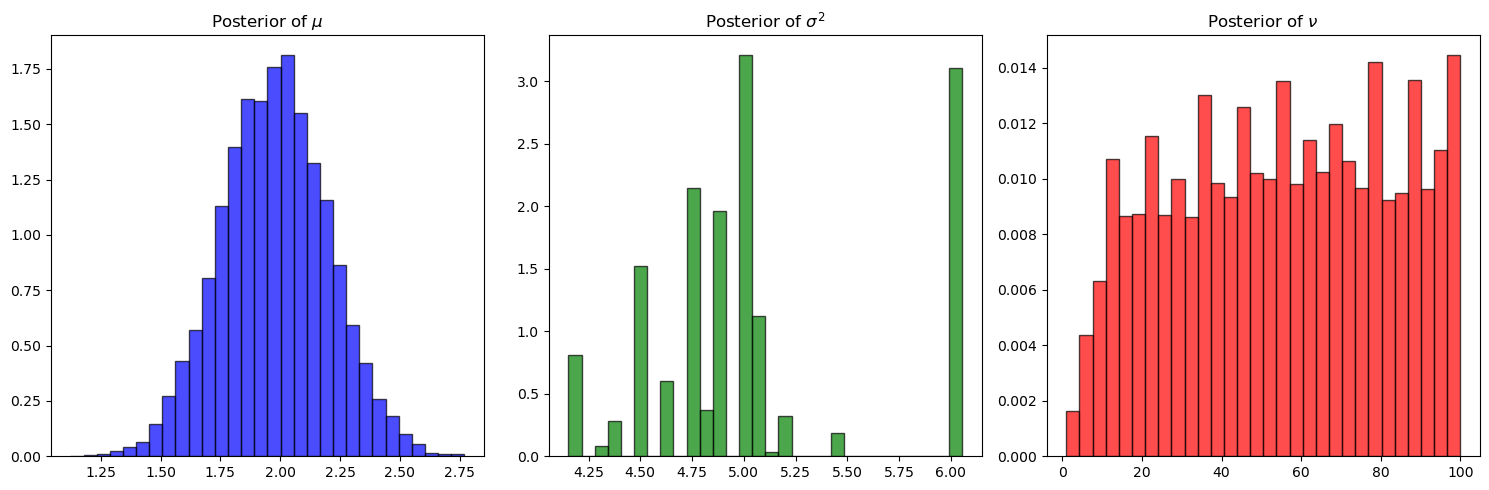

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import t, norm, gamma, halfnorm

# Sample data: t-distributed data with known parameters
n = 100  
true_mu = 2
true_sigma2 = 1.5
true_nu = 10
x = t.rvs(df=true_nu, loc=true_mu, scale=np.sqrt(true_sigma2), size=n)

# Hyperparameters for priors
mu_0 = np.mean(x)  # Prior mean for mu
tau_0_sq = 10      # Prior variance for mu
sigma_0_sq = 2     # Prior parameter for Half-Normal prior on sigma^2

num_iter = 10000
burn_in = 1000

# Initialize storage for samples
mu_samples = np.zeros(num_iter)
sigma2_samples = np.zeros(num_iter)
nu_samples = np.zeros(num_iter)

# Initial values
mu_samples[0] = np.mean(x)
sigma2_samples[0] = np.var(x)
nu_samples[0] = 10  # Starting value for nu

# Predefine the discrete uniform space for nu
nu_values = np.arange(1, 101)

for j in range(1, num_iter):
    # Gibbs Sampling mu 
    mu_current = mu_samples[j - 1]
    sigma2_current = sigma2_samples[j - 1]
    nu_current = nu_samples[j - 1]

    mu_star = (n * np.mean(x) / sigma2_current + mu_0 / tau_0_sq) / (n / sigma2_current + 1 / tau_0_sq)
    sigma_star_sq = 1 / (n / sigma2_current + 1 / tau_0_sq)
    mu_samples[j] = norm.rvs(mu_star, np.sqrt(sigma_star_sq))

    # MH for sigma^2
    sigma2_proposed = halfnorm.rvs(scale=np.sqrt(sigma_0_sq))  # Half-Normal proposal

    log_p_sigma2_current = - (sigma2_current ** 2) / (2 * sigma_0_sq) - np.sum(
        np.log(1 + ((x - mu_samples[j])**2) / (nu_current * sigma2_current))
    ) * (nu_current + 1) / 2
    log_p_sigma2_proposed = - (sigma2_proposed ** 2) / (2 * sigma_0_sq) - np.sum(
        np.log(1 + ((x - mu_samples[j])**2) / (nu_current * sigma2_proposed))
    ) * (nu_current + 1) / 2

    acceptance_ratio = np.exp(log_p_sigma2_proposed - log_p_sigma2_current)
    if np.random.uniform() < acceptance_ratio:
        sigma2_samples[j] = sigma2_proposed
    else:
        sigma2_samples[j] = sigma2_current

    # Discrete Sampling for v
    nu_proposed = np.random.choice(nu_values)  # Propose from discrete uniform

    log_p_nu_current = -np.sum(
        np.log(1 + ((x - mu_samples[j])**2) / (nu_current * sigma2_samples[j]))
    ) * (nu_current + 1) / 2
    log_p_nu_proposed = -np.sum(
        np.log(1 + ((x - mu_samples[j])**2) / (nu_proposed * sigma2_samples[j]))
    ) * (nu_proposed + 1) / 2

    acceptance_ratio = np.exp(log_p_nu_proposed - log_p_nu_current)
    if np.random.uniform() < acceptance_ratio:
        nu_samples[j] = nu_proposed
    else:
        nu_samples[j] = nu_current

# Burn-in period removal
mu_samples = mu_samples[burn_in:]
sigma2_samples = sigma2_samples[burn_in:]
nu_samples = nu_samples[burn_in:]

# Plot posterior distributions
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].hist(mu_samples, bins=30, color="blue", edgecolor="black", density=True, alpha=0.7)
ax[0].set_title("Posterior of $\\mu$")

ax[1].hist(sigma2_samples, bins=30, color="green", edgecolor="black", density=True, alpha=0.7)
ax[1].set_title("Posterior of $\\sigma^2$")

ax[2].hist(nu_samples, bins=30, color="red", edgecolor="black", density=True, alpha=0.7)
ax[2].set_title("Posterior of $\\nu$")

plt.tight_layout()
plt.show()

### Q2
**Question:** 

*Implement the specification above using `PyMC` where you can explore inference on $\nu$ at different sample sizes. Provide a summarization and explanation of your findings.*

**Answer:**

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [mu, sigma2]
>Metropolis: [nu]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 2 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [mu, sigma2]
>Metropolis: [nu]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 2 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [mu, sigma2]
>Metropolis: [nu]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 2 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


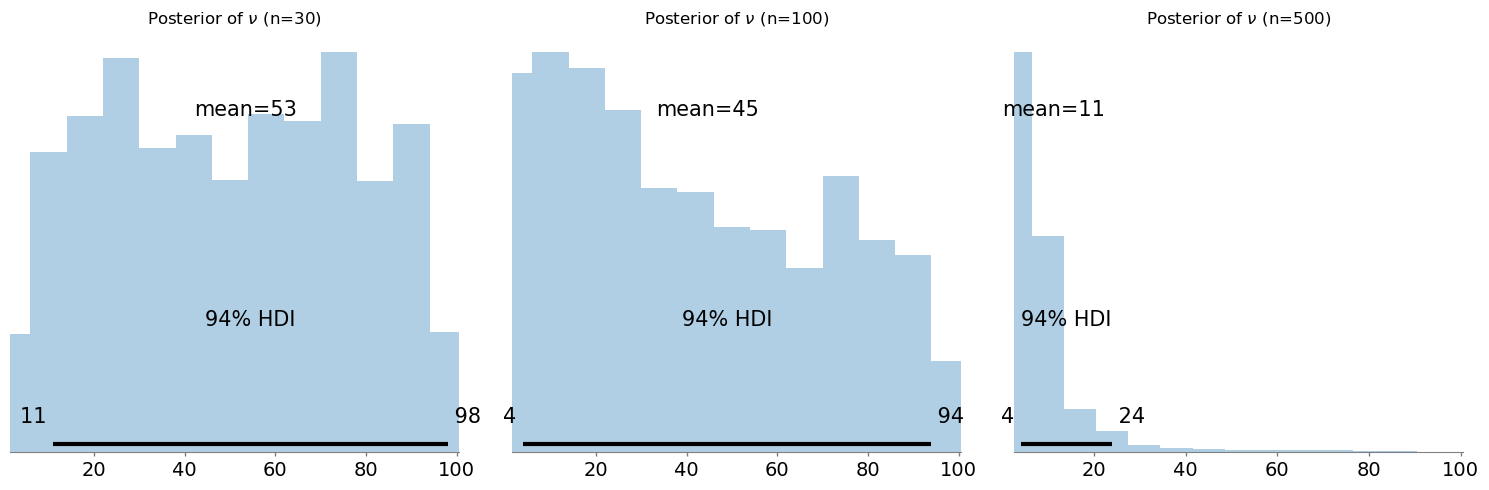

In [2]:
import pymc as pm
import numpy as np
import arviz as az
import matplotlib.pyplot as plt

# Generate data from a t-distribution
def generate_t_data(n, mu=2, sigma2=1.5, nu=10):
    return np.random.standard_t(df=nu, size=n) * np.sqrt(sigma2) + mu

# Different sample sizes 
sample_sizes = [30, 100, 500]

# Prior settings
mu_0 = 0
tau_0_sq = 10  # Prior variance for mu
sigma_0_sq = 2  # Prior scale for Half-Normal
nu_values = np.arange(1, 101)  # Discrete uniform range for nu

# Store results for different sample sizes
posterior_results = {}

for n in sample_sizes:
    x = generate_t_data(n)

    with pm.Model() as t_model:
        # Priors
        mu = pm.Normal("mu", mu=mu_0, sigma=np.sqrt(tau_0_sq))  
        sigma2 = pm.HalfNormal("sigma2", sigma=np.sqrt(sigma_0_sq))  
        nu = pm.DiscreteUniform("nu", lower=1, upper=100)  

        # Likelihood
        obs = pm.StudentT("obs", nu=nu, mu=mu, sigma=pm.math.sqrt(sigma2), observed=x)

        # Inference
        trace = pm.sample(2000, tune=1000, return_inferencedata=True, cores=2)

    posterior_results[n] = trace

# Plot posteriors for nu across sample sizes
fig, axes = plt.subplots(1, len(sample_sizes), figsize=(15, 5))
for i, n in enumerate(sample_sizes):
    az.plot_posterior(posterior_results[n], var_names=["nu"], ax=axes[i])
    axes[i].set_title(f"Posterior of $\\nu$ (n={n})")

plt.tight_layout()
plt.show()

The histograms created for varying sample sizes show that the posterior distribution of $\nu$ becomes more concentrated around the true value as the sample size increases. With small n, the model is highly uncertain about $\nu$ (as shown by the large range of the 94% HDI), failing to correctly identify the heavy tails. With larger n, the posterior correctly concentrates around the true $\nu$, detecting heavy tails more reliably. This suggests that increasing the sample size significantly helps obtain a more precise estimate of $\nu$.

### Q3
**Question:** 

Let $p(\tau_i)$ be $\require{cancel} \textrm{gamma}\big(\tau_i | \alpha = \frac{\nu}{2}, \overset{\textrm{rate}\xcancel{\textrm{scale}}}{\beta = \frac{\nu}{2}}\big)$ and let $p(y_i|\tau_i)$ be $\textrm{N}(y_i | 0,\tau_i)$ and now integrate out the uncertainty in $\tau_i$ and see what distribution is left over for $y_i$.

*Go look at the gamma distribution and remember that you know that the integrals of unnormalized densities are the inverse of their normalizing constants. Then go look at the t distribution and determine what distribution the following expression defines. Then explain why the behavior demonstrated here is analagous to that of the posterior predictive distribution.*

$$\int p(y_i|\tau_i) p(\tau_i)  d\tau_i = \int \sqrt{\frac{\tau_i}{2\pi}}e^{-\frac{1}{2}\tau_i y_i^2} \frac {\frac{\nu}{2}^{\frac{\nu}{2}}}{\Gamma \left(\frac{\nu}{2}\right)} \tau_i^{\frac{\nu}{2}-1}e^{-\frac{\nu}{2}\tau_i} d\tau_i$$

**Answer:**

$P(y_i) = \int P(y_i | \tau_i) P(\tau_i) d\tau_i$

$P(y_i) = \int \sqrt{\frac{\tau_i}{2\pi}} e^{-\frac{1}{2} \tau_i y_i^2} \frac{\left(\frac{\nu}{2} \right)^{\nu/2}}{\Gamma(\nu/2)} \tau_i^{\nu/2 - 1} e^{-\frac{\nu}{2} \tau_i} d\tau_i$

Rearrange terms:

$P(y_i) = \frac{\left(\frac{\nu}{2} \right)^{\nu/2}}{\Gamma(\nu/2)} \frac{1}{\sqrt{2\pi}} \int \tau_i^{\frac{\nu+1}{2} - 1} e^{-\left(\frac{1}{2} y_i^2 + \frac{\nu}{2} \right) \tau_i} d\tau_i$

The standard gamma integral:

$\int_0^\infty x^{a-1} e^{-bx} dx = \frac{\Gamma(a)}{b^a}$

matches our integral above with:

$a = \frac{\nu+1}{2}, \quad b = \frac{1}{2} y_i^2 + \frac{\nu}{2}$

Thus, 

$\int \tau_i^{\frac{\nu+1}{2} - 1} e^{-\left(\frac{1}{2} y_i^2 + \frac{\nu}{2} \right) \tau_i} d\tau_i = \frac{\Gamma(\frac{\nu+1}{2})}{\left(\frac{1}{2} y_i^2 + \frac{\nu}{2} \right)^{(\nu+1)/2}}$

**Final Expression:**

$P(y_i) = \frac{\left(\frac{\nu}{2} \right)^{\nu/2}}{\Gamma(\nu/2)} \frac{1}{\sqrt{2\pi}} \frac{\Gamma(\frac{\nu+1}{2})}{\left(\frac{1}{2} y_i^2 + \frac{\nu}{2} \right)^{(\nu+1)/2}}$

Rewriting:

$P(y_i) = \frac{\Gamma(\frac{\nu+1}{2})}{\Gamma(\nu/2)} \frac{1}{\sqrt{\nu \pi}} \left(1 + \frac{y_i^2}{\nu} \right)^{-(\nu+1)/2}$

Thus, we conclude:

$y_i \sim t_{\nu}$

This matches the **Student's t-distribution**.

The derivation result shows that marginalizing out $\tau_i$ results in a t-distribution. This is analogous to the posterior predictive distribution in Bayesian statistics because, when integrating out uncertainty in the precision $\tau_i$, the resulting distribution becomes heavier-tailed than the normal distribution. This occurs because the Gamma prior on precision adds uncertainty to the variance, which leads to a t-distribution. This behavior is commonly seen in Bayesian inference, where our modeling naturally introduces t-distributed effects due to integrating out scale parameters.